In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle
from pathlib import Path
from importlib import reload
from IPython.display import clear_output

from roman_cgi_iefc import cgi
from roman_cgi_iefc import iefc_sim as iefc
from roman_cgi_iefc import iefc_sim_2dm as iefc2

import misc

import proper
proper.prop_use_fftw(DISABLE=False)
# proper.prop_fftw_wisdom( 1024 ) 

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

# Initialize mode

In [3]:
reload(cgi)

hlci = cgi.CGI_PROPER(use_opds=False, use_fieldstop=False, quiet=True)
npsf = hlci.npsf
Nact = hlci.Nact

# Create dark hole ROI to calibrate and control

(4096,) 692


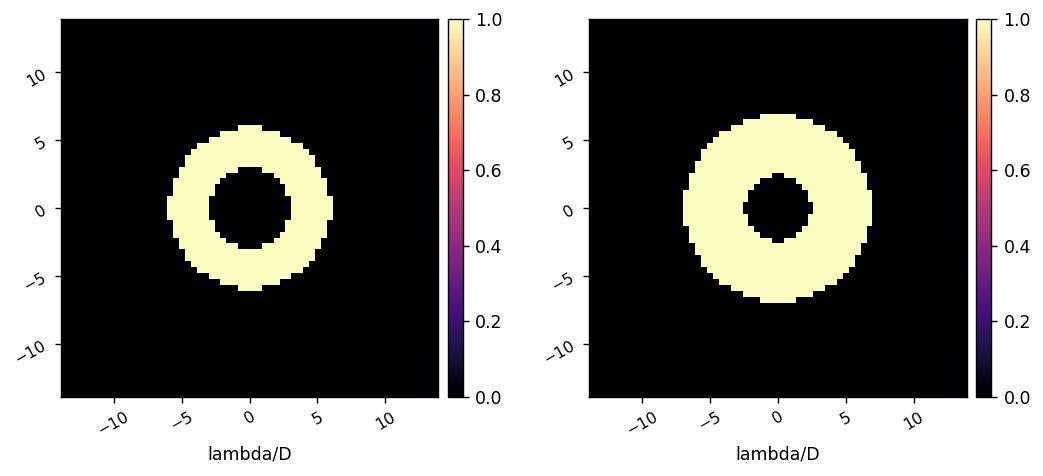

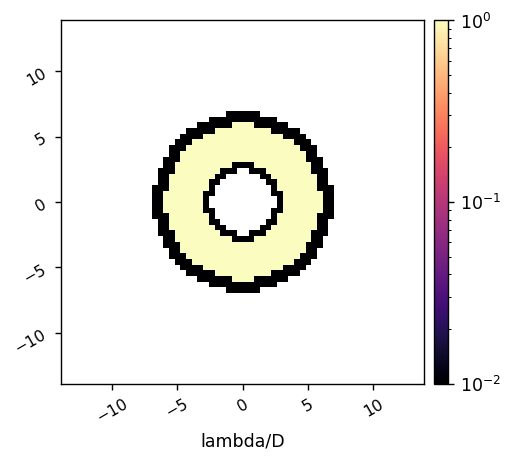

In [4]:
reload(iefc2)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 6

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : ''
}
dh_mask = iefc2.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.5,
    'outer_radius' : owa+1,
    'edge_position' : edge,
    'direction' : ''
}
control_mask = iefc2.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

print(control_mask.shape, control_mask.sum())
misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=hlci.psf_pixelscale_lamD, pxscl2=hlci.psf_pixelscale_lamD)
misc.myimshow(weights.reshape(npsf,npsf), lognorm=True, pxscl=hlci.psf_pixelscale_lamD)

# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
Calibration modes required: 296


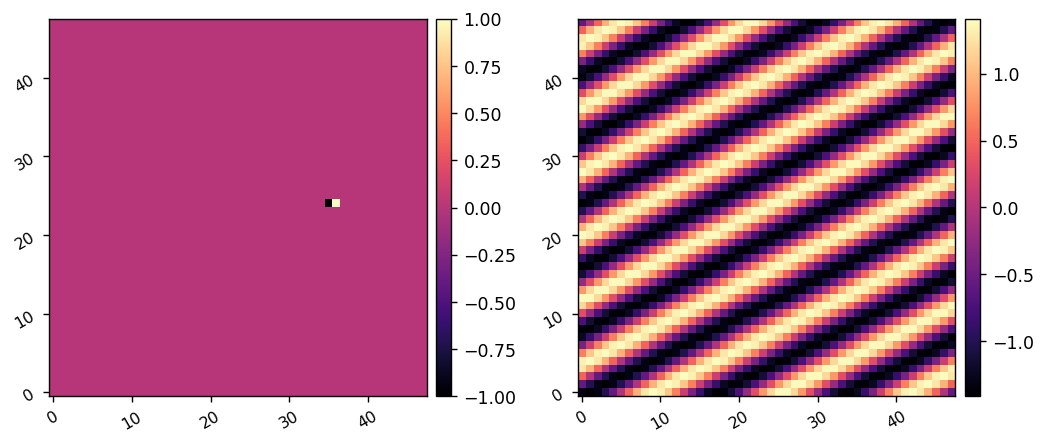

In [5]:
reload(iefc2)

fourier_modes, fx, fy = iefc2.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)
probe_modes = iefc2.create_probe_poke_modes(hlci.Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)

calibration_amplitude = 0.006 * hlci.wavelength.to(u.m).value
probe_amplitude = 0.05 * hlci.wavelength.to(u.m).value

print('Calibration modes required: {:d}'.format(fourier_modes.shape[0]))
calibration_mode = fourier_modes[10]
misc.myimshow2((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)), calibration_mode.reshape(Nact,Nact))

# Testing

In [32]:
slopes_1 = []
slopes_2 = []
images_1 = []
images_2 = []
    
slope_1, slope_2 = (0, 0)
for s in [-1, 1]: # We need a + and - probe to estimate the jacobian
    # DM1: Set the DM to the correct state
    hlci.add_dm1(s * calibration_amplitude * calibration_mode)
    differential_images_1, single_images_1 = iefc2.take_measurement(hlci, probe_modes, probe_amplitude, 
                                                                    return_all=True)

    slope_1 += s * differential_images_1 / (2 * calibration_amplitude)
    images_1.append(single_images_1)

    hlci.add_dm1(-s * calibration_amplitude * calibration_mode) # remove the calibrated mode from DM1

    # DM2: Set the DM to the correct state
    hlci.add_dm2(s * calibration_amplitude * calibration_mode)
    differential_images_2, single_images_2 = iefc2.take_measurement(hlci, probe_modes, probe_amplitude, 
                                                                    return_all=True)

    slope_2 += s * differential_images_2 / (2 * calibration_amplitude)
    images_2.append(single_images_2)

    hlci.add_dm2(-s * calibration_amplitude * calibration_mode) # remove the calibrated mode from DM2
    
slopes_1.append(slope_1)
slopes_2.append(slope_2)

In [39]:
slopes_1 = np.array(slopes_1)
slopes_2 = np.array(slopes_2)
images_1 = np.array(images_1)
images_2 = np.array(images_2)

slopes = np.concatenate((slopes_1, slopes_2), axis=1)
images = np.concatenate((images_1, images_2), axis=1)

slopes_1.shape, slopes.shape, images_1.shape, images.shape

((1, 2, 4096), (1, 4, 4096), (2, 4, 4096), (2, 8, 4096))

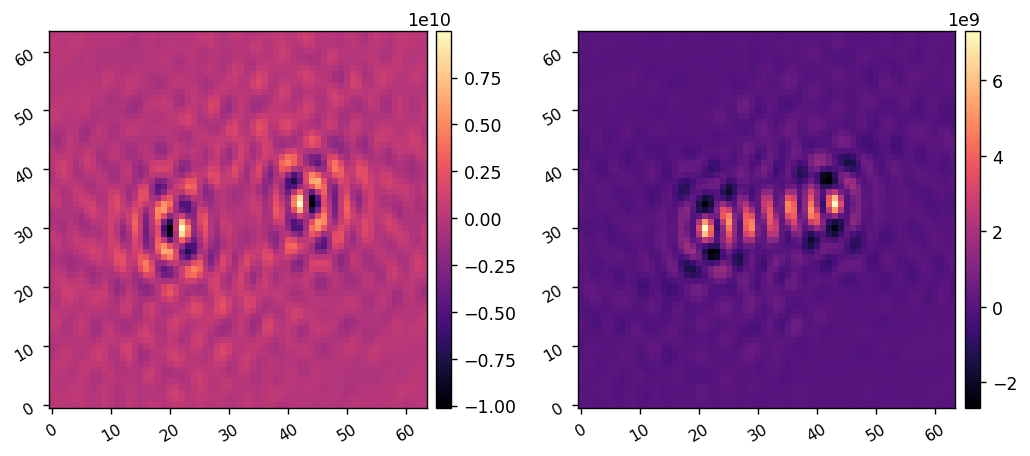

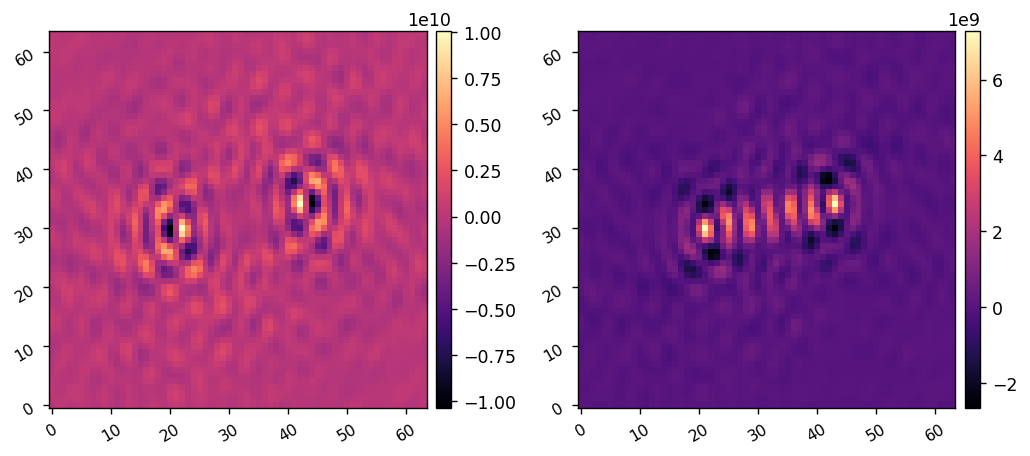

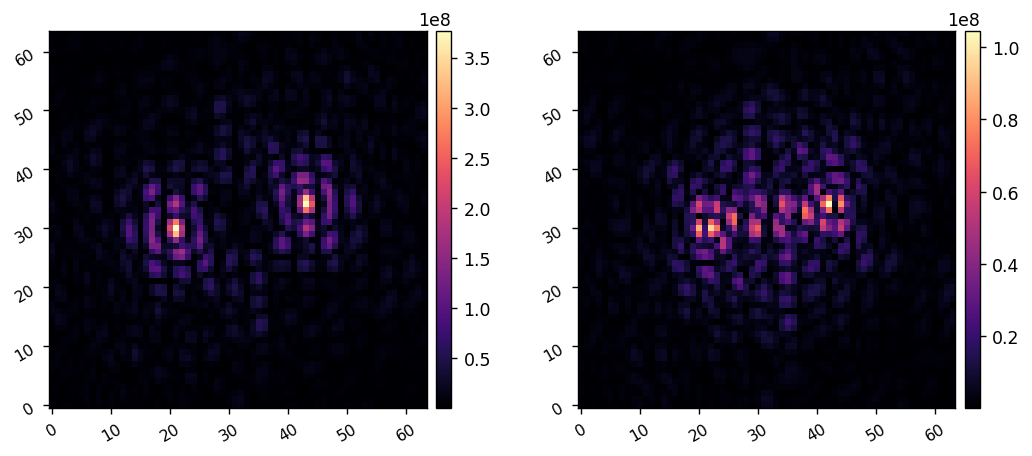

In [40]:
misc.myimshow2(slope_1[0].reshape(npsf,npsf), slope_1[1].reshape(npsf,npsf))
misc.myimshow2(slope_2[0].reshape(npsf,npsf), slope_2[1].reshape(npsf,npsf))
misc.myimshow2(np.abs(slope_1[0]-slope_2[0]).reshape(npsf,npsf), 
               np.abs(slope_1[1]-slope_2[1]).reshape(npsf,npsf))


# Calibrate IEFC (or load in previous calibration data)

In [5]:
reload(iefc2)

response_cube, calibration_cube = iefc2.calibrate(hlci, probe_amplitude, probe_modes, 
                                                  calibration_amplitude, fourier_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 16 in 39.763s
	Calibrated mode 2 / 16 in 76.991s
	Calibrated mode 3 / 16 in 115.104s
	Calibrated mode 4 / 16 in 154.234s
	Calibrated mode 5 / 16 in 191.500s
	Calibrated mode 6 / 16 in 231.651s
	Calibrated mode 7 / 16 in 270.533s
	Calibrated mode 8 / 16 in 309.459s
	Calibrated mode 9 / 16 in 349.122s
	Calibrated mode 10 / 16 in 388.077s
	Calibrated mode 11 / 16 in 426.591s
	Calibrated mode 12 / 16 in 463.159s
	Calibrated mode 13 / 16 in 501.027s
	Calibrated mode 14 / 16 in 539.570s
	Calibrated mode 15 / 16 in 579.822s
	Calibrated mode 16 / 16 in 621.478s
Calibration complete.


In [6]:
print(response_cube.shape, calibration_cube.shape)

response_hdu = fits.PrimaryHDU(data=response_cube)
response_hdu.writeto(data_dir/'response-data'/'hlc_response_cube_annular_3to6.fits', overwrite=True)

calib_hdu = fits.PrimaryHDU(data=calibration_cube)
calib_hdu.writeto(data_dir/'calibration-data'/'hlc_calibration_cube_ann_3to6.fits', overwrite=True)

(16, 4, 4096) (32, 8, 4096)
